### Heart Disease Model Training
#### DSSA 5201 - Machine Learning Fundamentals
#### Louise Ramos | 04/23/2024

In [347]:
# import libraries and packages
import numpy as np
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

#Ignore seaborn deprecation warning for distplot
warnings.filterwarnings("ignore")

In [348]:
# Reading in csv as Pandas DataFrame
heart_frame = pd.read_csv("heart_disease_2022.csv")

# Convert 'Yes' to 1 and 'No' to 0
mapping = {'Yes': 1, 'No': 0}
heart_frame["HadHeartAttack"] = heart_frame["HadHeartAttack"].map(mapping)

# Rename some columns
heart_frame = heart_frame.rename(columns={'RaceEthnicityCategory': 'Race', 'AgeCategory': 'Age', 'WeightInKilograms': 'Weight (kg)', 'HeightInMeters': "Height (m)"})
# Drop state column and only focus on a subset of columns
heart_frame = heart_frame[['Sex', 'GeneralHealth', 'PhysicalActivities','DifficultyWalking', 'SmokerStatus', 'Race', 'Age', 'AlcoholDrinkers', 
                           'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI', 'Weight (kg)', 'Height (m)', 'HadHeartAttack']]

# Simplify some of the data entries
ethnicity_mapping = {"Black only, Non-Hispanic": "Black", "White only, Non-Hispanic": "White", "Multiracial, Non-Hispanic": "Multiracial", "Other race only, Non-Hispanic": "Other"}
heart_frame['Race'] = heart_frame['Race'].replace(ethnicity_mapping)
smoker_mapping = {"Current smoker - now smokes every day": "Current", "Former smoker": "Former", "Never smoked": "Never", "Current smoker - now smokes some days": "Current"}
heart_frame['SmokerStatus'] = heart_frame['SmokerStatus'].replace(smoker_mapping)
heart_frame["Age"] = heart_frame["Age"].str.strip("Age ")

# Save updated frame
heart_frame.to_csv("heart_disease_2022_update.csv", index=False)

In [349]:
# Previewing DataFrame (Left is Target)
print(heart_frame.head())

# Check DataFrame dimensions
print(f"The DataFrame size is {heart_frame.shape}")

      Sex GeneralHealth PhysicalActivities DifficultyWalking SmokerStatus  \
0  Female     Very good                Yes                No       Former   
1    Male     Very good                Yes                No       Former   
2    Male     Very good                 No               Yes       Former   
3  Female          Fair                Yes               Yes        Never   
4  Female          Good                Yes                No        Never   

    Race          Age AlcoholDrinkers  PhysicalHealthDays  MentalHealthDays  \
0  White     65 to 69              No                 4.0               0.0   
1  White     70 to 74              No                 0.0               0.0   
2  White     75 to 79             Yes                 0.0               0.0   
3  White  80 or older              No                 5.0               0.0   
4  White  80 or older              No                 3.0              15.0   

   SleepHours    BMI  Weight (kg)  Height (m)  HadHeartAttack 

In [350]:
# Counting NA values in all columns
na_count = heart_frame.isna().sum()
print(na_count)

# There are no NAs in the heart dataset

Sex                   0
GeneralHealth         0
PhysicalActivities    0
DifficultyWalking     0
SmokerStatus          0
Race                  0
Age                   0
AlcoholDrinkers       0
PhysicalHealthDays    0
MentalHealthDays      0
SleepHours            0
BMI                   0
Weight (kg)           0
Height (m)            0
HadHeartAttack        0
dtype: int64


In [351]:
# check data types for each column
heart_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Sex                 246022 non-null  object 
 1   GeneralHealth       246022 non-null  object 
 2   PhysicalActivities  246022 non-null  object 
 3   DifficultyWalking   246022 non-null  object 
 4   SmokerStatus        246022 non-null  object 
 5   Race                246022 non-null  object 
 6   Age                 246022 non-null  object 
 7   AlcoholDrinkers     246022 non-null  object 
 8   PhysicalHealthDays  246022 non-null  float64
 9   MentalHealthDays    246022 non-null  float64
 10  SleepHours          246022 non-null  float64
 11  BMI                 246022 non-null  float64
 12  Weight (kg)         246022 non-null  float64
 13  Height (m)          246022 non-null  float64
 14  HadHeartAttack      246022 non-null  int64  
dtypes: float64(6), int64(1), object(8)

In [352]:
# Get numerical columns
numerical_columns = pd.DataFrame(heart_frame[heart_frame.select_dtypes(include = ["float", "int"]).columns])

# Preview numerical columns
numerical_columns.head()

,PhysicalHealthDays,MentalHealthDays,SleepHours,BMI,Weight (kg),Height (m),HadHeartAttack
0,4.0,0.0,9.0,27.99,71.67,1.60,0
1,0.0,0.0,6.0,30.13,95.25,1.78,0
2,0.0,0.0,8.0,31.66,108.86,1.85,0
3,5.0,0.0,9.0,31.32,90.72,1.70,0
4,3.0,15.0,5.0,33.07,79.38,1.55,0


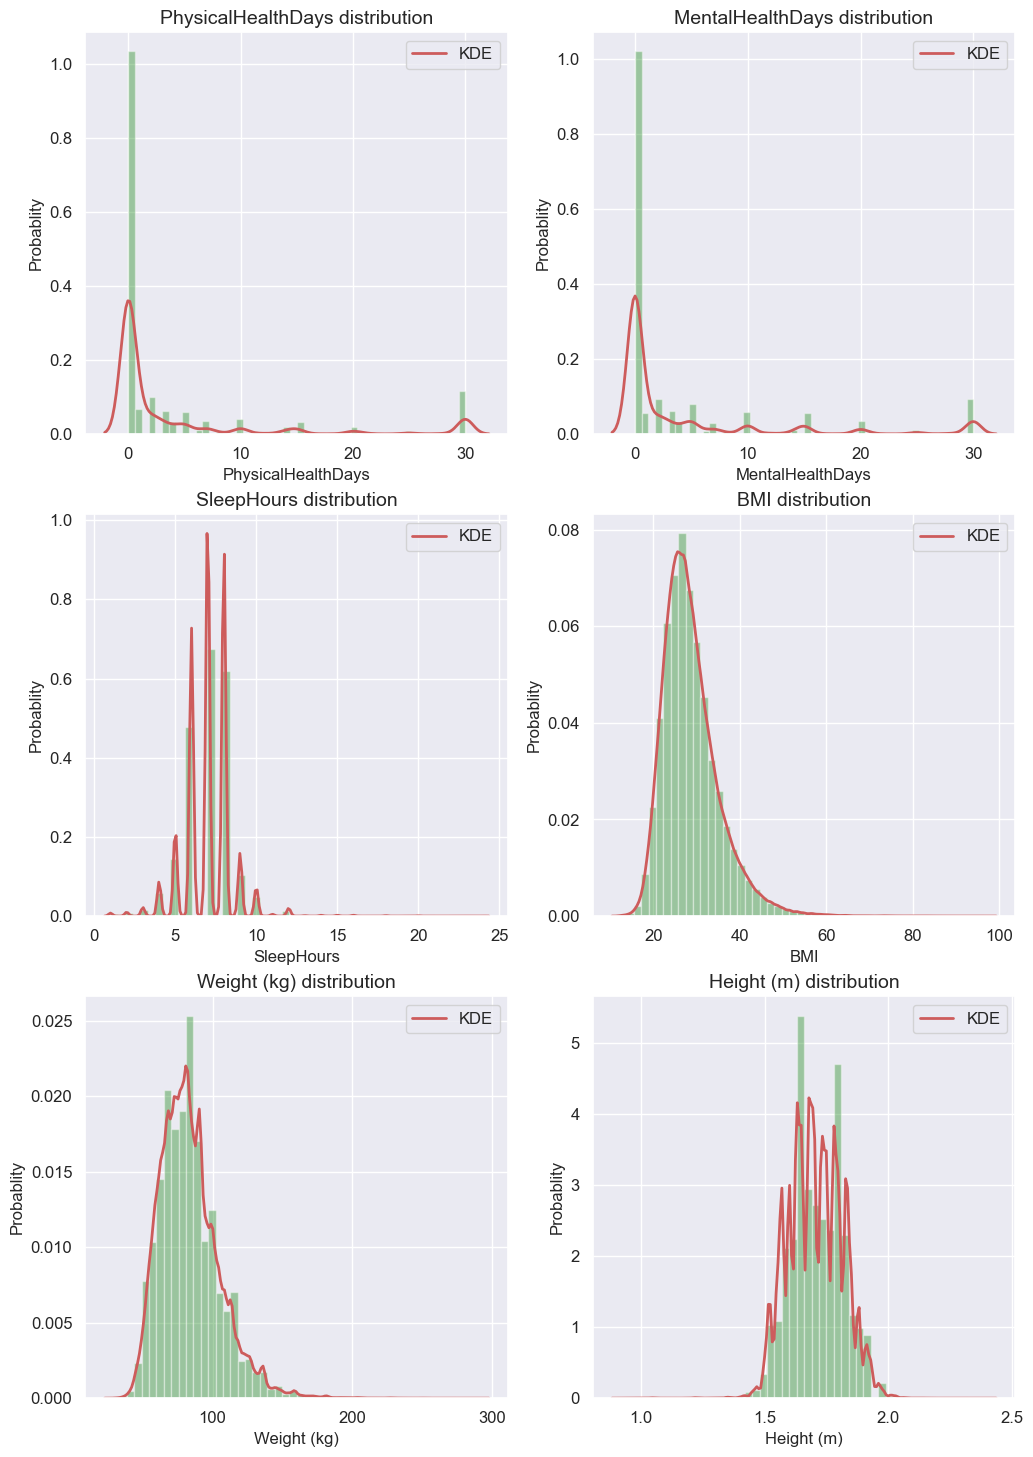

In [353]:
# Visualize variable distribution
plt.figure(figsize=(12,24))

numerical_columns = numerical_columns.drop(["HadHeartAttack"], axis=1)

# visualize distributions of numerical columns
for i, column in enumerate(numerical_columns.columns):
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.distplot(numerical_columns[column], color='forestgreen', 
                 kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
    plt.title(column+' distribution', fontsize=14)
    plt.ylabel('Probablity', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['KDE'], prop={"size":12})

In [354]:
# Summary statistics for DataFrame
heart_frame.describe().T

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,246022.0,4.119026,8.405844,0.00,0.00,0.00,3.00,30.00
MentalHealthDays,246022.0,4.167140,8.102687,0.00,0.00,0.00,4.00,30.00
SleepHours,246022.0,7.021331,1.440681,1.00,6.00,7.00,8.00,24.00
BMI,246022.0,28.668136,6.513973,12.02,24.27,27.46,31.89,97.65
Weight (kg),246022.0,83.615179,21.323156,28.12,68.04,81.65,95.25,292.57
Height (m),246022.0,1.705150,0.106654,0.91,1.63,1.70,1.78,2.41
HadHeartAttack,246022.0,0.054609,0.227216,0.00,0.00,0.00,0.00,1.00


In [355]:
# summary statistics for individuals who did not have heart disease
heart_frame[heart_frame["HadHeartAttack"] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,232587.0,3.849484,8.095169,0.00,0.00,0.00,3.00,30.00
MentalHealthDays,232587.0,4.116718,8.013001,0.00,0.00,0.00,4.00,30.00
SleepHours,232587.0,7.020074,1.412503,1.00,6.00,7.00,8.00,24.00
BMI,232587.0,28.620521,6.507084,12.02,24.21,27.44,31.87,97.65
Weight (kg),232587.0,83.418204,21.293254,28.12,68.04,81.65,95.25,292.57
Height (m),232587.0,1.704559,0.106589,0.91,1.63,1.70,1.78,2.41
HadHeartAttack,232587.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00


In [356]:
# summary statistics for individuals who did have heart disease
heart_frame[heart_frame["HadHeartAttack"] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,13435.0,8.785337,11.678401,0.00,0.00,2.00,15.00,30.00
MentalHealthDays,13435.0,5.040045,9.480304,0.00,0.00,0.00,5.00,30.00
SleepHours,13435.0,7.043096,1.862036,1.00,6.00,7.00,8.00,23.00
BMI,13435.0,29.492435,6.577941,12.34,25.10,28.48,32.76,95.66
Weight (kg),13435.0,87.025207,21.551631,31.75,72.57,84.37,99.79,231.79
Height (m),13435.0,1.715383,0.107264,0.91,1.63,1.73,1.80,2.41
HadHeartAttack,13435.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00


In [357]:
# Size before drop
print(heart_frame.shape)
# Dropping rows where any column contains an outlier (Greater than 3 stdev from the mean)
heart_frame = heart_frame[(np.abs(stats.zscore(numerical_columns)) < 3).all(axis=1)]
# Size after drop
print(heart_frame.shape)

(246022, 15)
(213401, 15)


Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI',
       'Weight (kg)', 'Height (m)'],
      dtype='object')


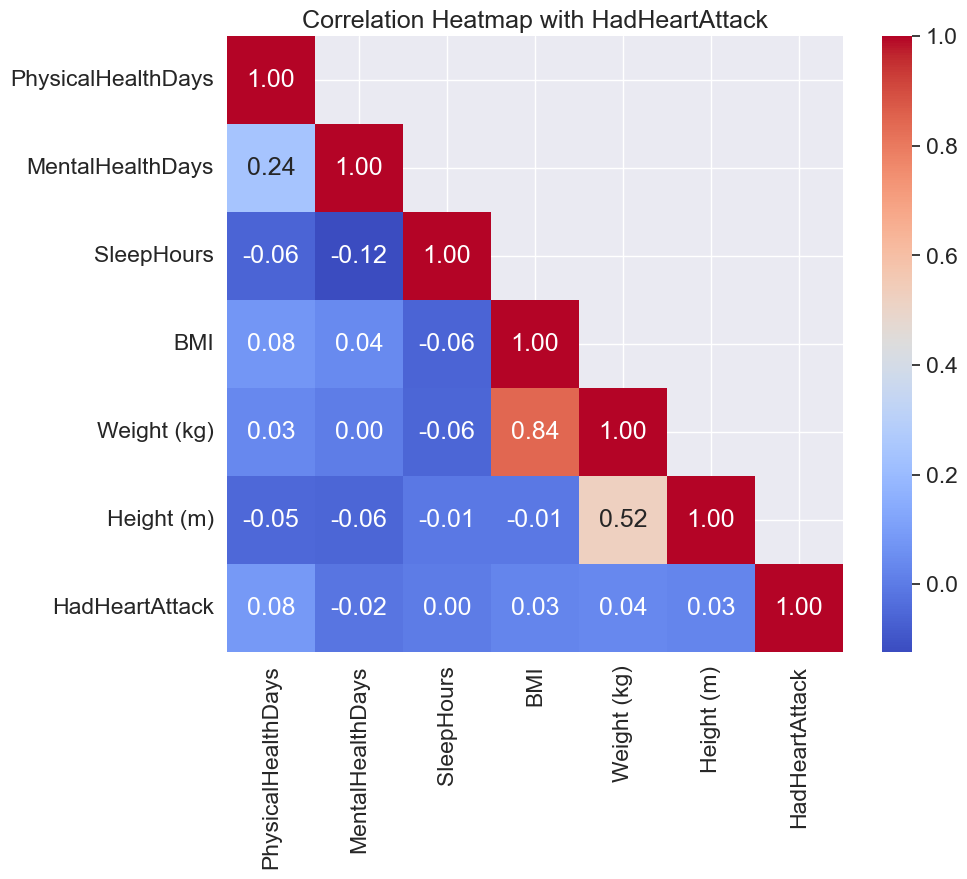

In [358]:
# Concatenate the target column with the numerical columns
numerical_columns = pd.DataFrame(heart_frame[heart_frame.select_dtypes(include = ["float", "int"]).columns])
cleaned_numerical_columns = numerical_columns.drop(["HadHeartAttack"], axis=1)
print(cleaned_numerical_columns.columns)
matrix_columns = list(numerical_columns)
correlation_matrix = heart_frame[matrix_columns].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask, k=1)] = True

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap with HadHeartAttack')
plt.show()

In [359]:
# Weight and Number of bad physical health days seem to be the strongest predictors but are still not very strong

In [360]:
# Scale numeric variables
sc = StandardScaler()
scaled_numerical_columns = pd.DataFrame(sc.fit_transform(cleaned_numerical_columns), columns = cleaned_numerical_columns.columns)


# Preview DataFrame stats
print(scaled_numerical_columns.head())

   PhysicalHealthDays  MentalHealthDays  SleepHours       BMI  Weight (kg)  \
0            0.452580         -0.491846    1.657397 -0.028416    -0.554194   
1           -0.452097         -0.491846   -0.890259  0.351878     0.680804   
2           -0.452097         -0.491846    0.808178  0.623771     1.393626   
3            0.678749         -0.491846    1.657397  0.563350     0.443546   
4            0.226411          2.492794   -1.739477  0.874338    -0.150384   

   Height (m)  
0   -1.019584  
1    0.705800  
2    1.376783  
3   -0.061037  
4   -1.498857  


In [361]:
# Get the categorical variables 
categorical_columns = pd.DataFrame(heart_frame[heart_frame.select_dtypes(include = ["object"]).columns])
categorical_columns.columns

Index(['Sex', 'GeneralHealth', 'PhysicalActivities', 'DifficultyWalking',
       'SmokerStatus', 'Race', 'Age', 'AlcoholDrinkers'],
      dtype='object')

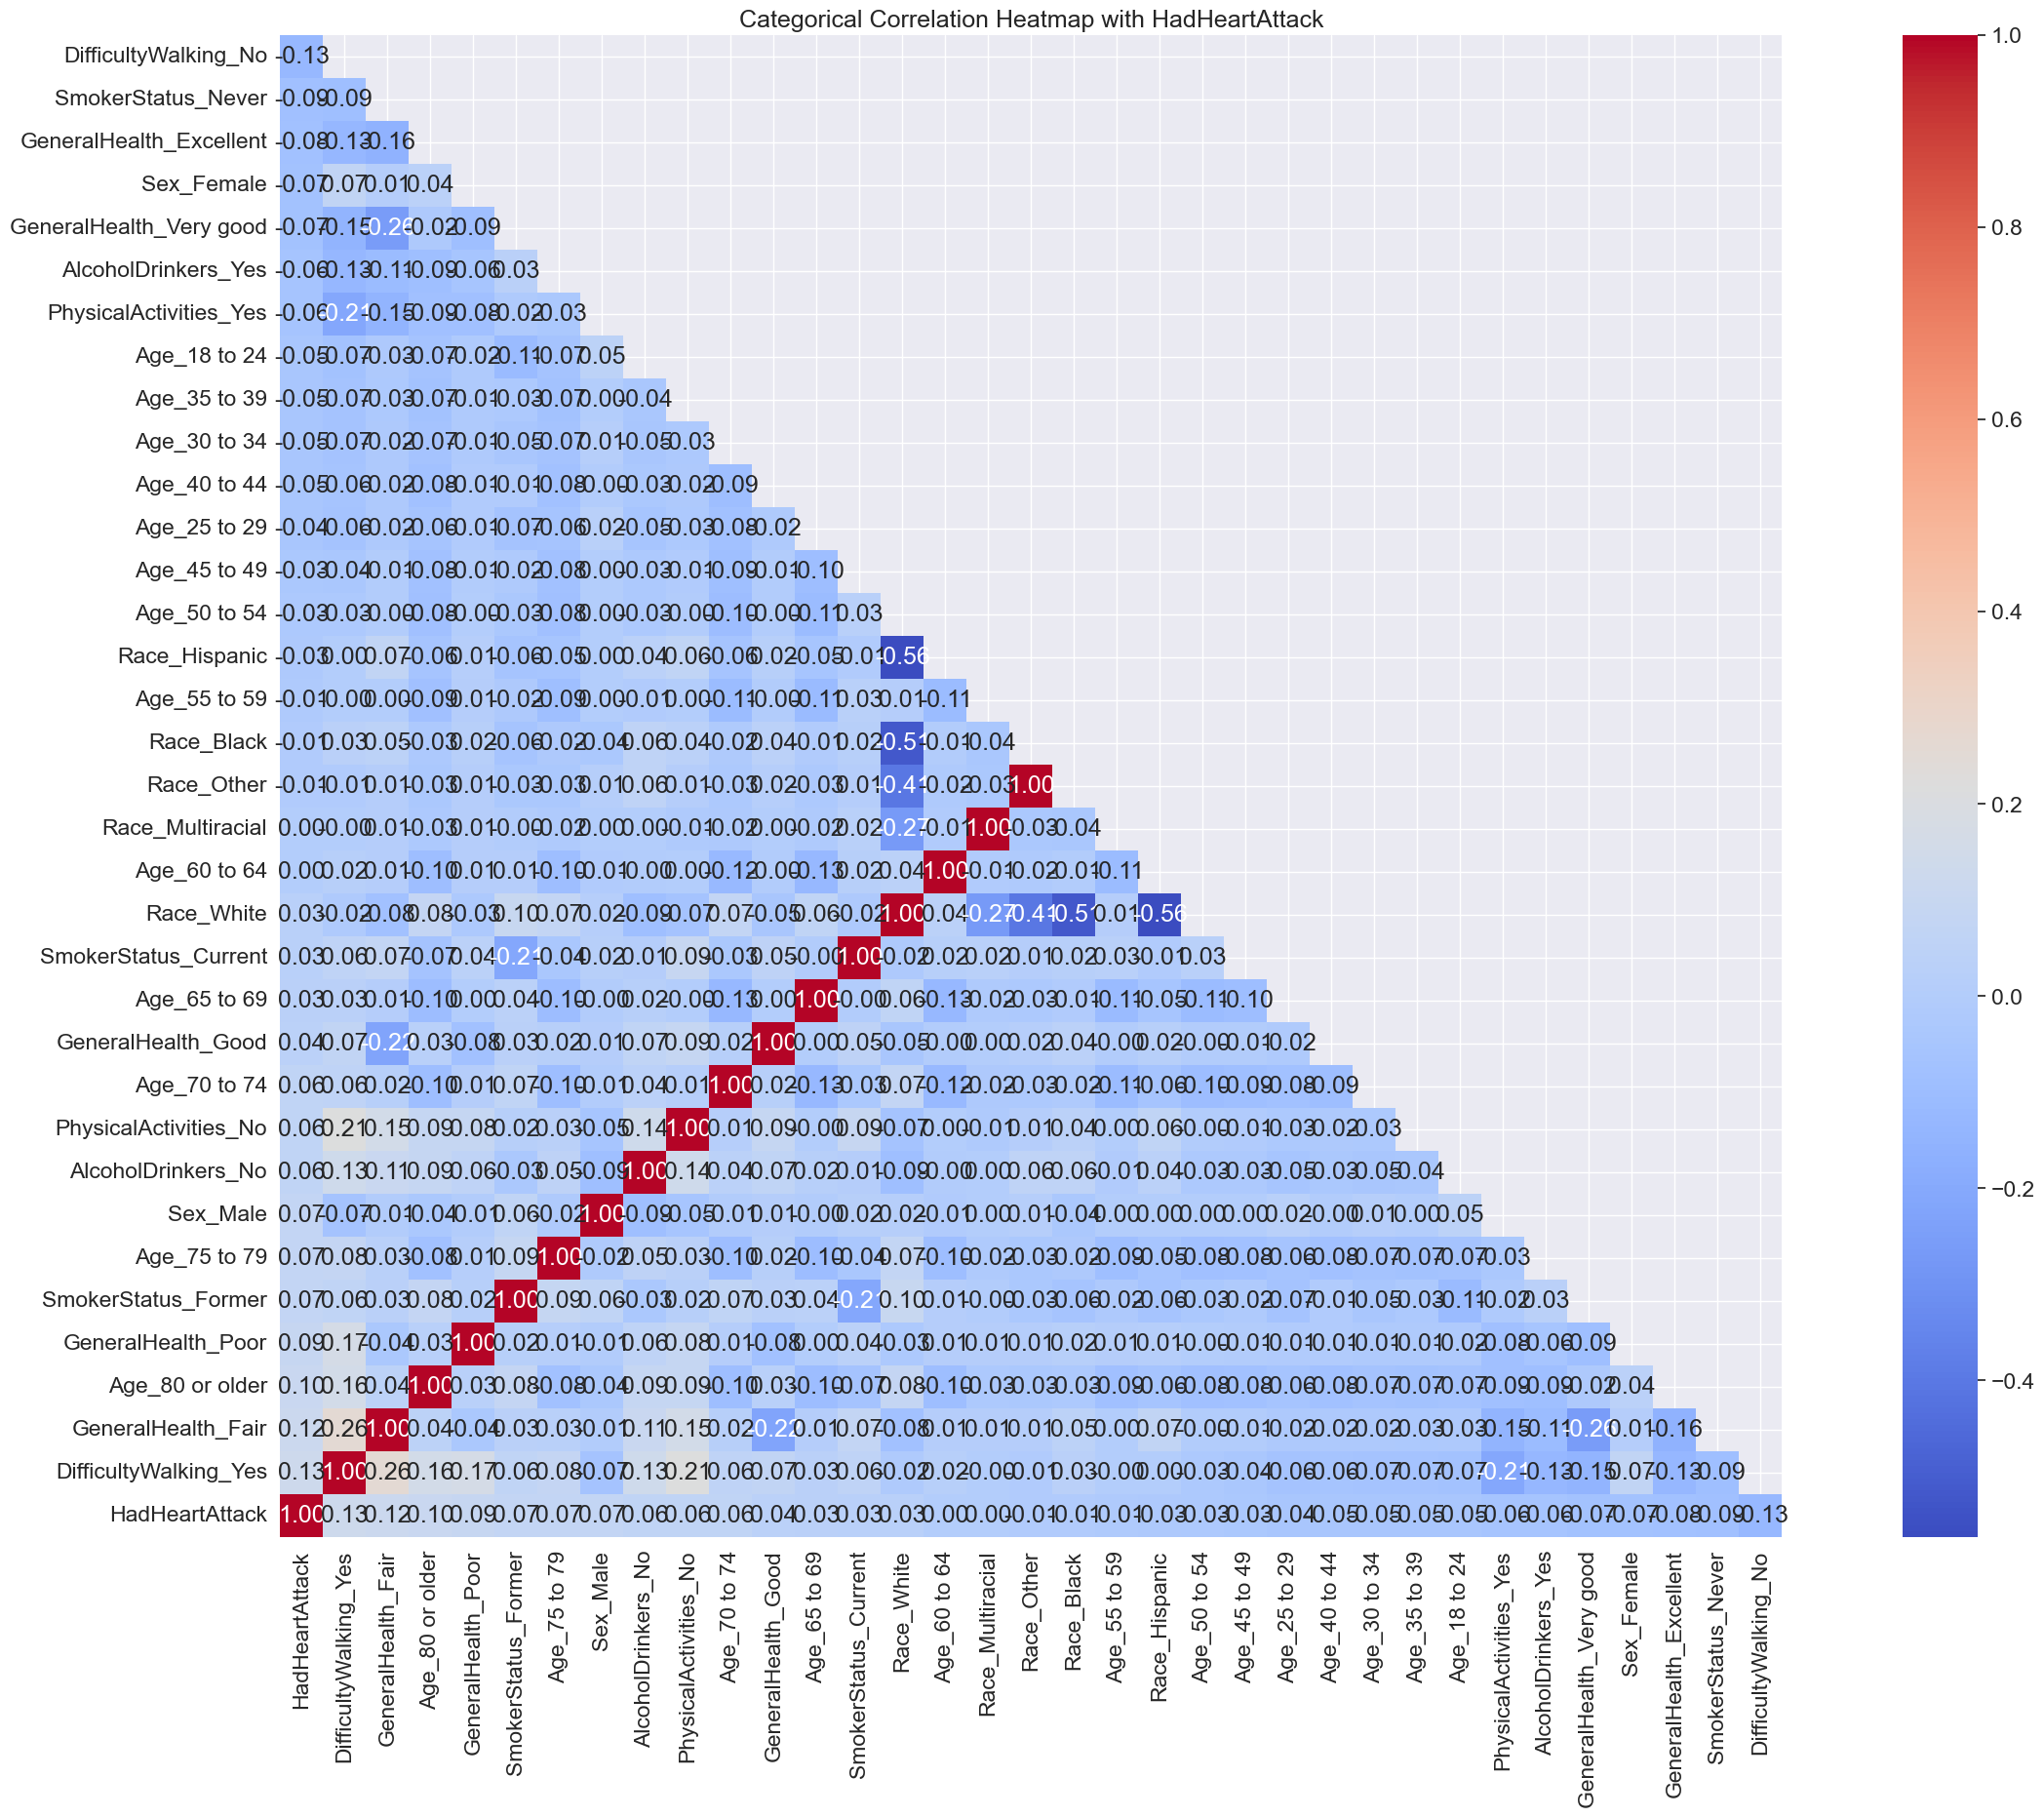

In [362]:
# one hot encode the categorical variables
encoded_categorical = pd.get_dummies(categorical_columns)
categorical_columns_corr = pd.concat([encoded_categorical, heart_frame[["HadHeartAttack"]]], axis=1)
correlation = categorical_columns_corr.corr().sort_values("HadHeartAttack", axis=1, ascending=False)
correlation = correlation.sort_values("HadHeartAttack", axis=0, ascending=True)
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask, k=1)] = True

# Create a heatmap
plt.figure(figsize=(32, 20))
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Categorical Correlation Heatmap with HadHeartAttack')
plt.show()

In [363]:
# Concat the numerical and categorical (with encoded)
# Reset index for both scaled numerical and encoded categorical
scaled_numerical_columns.reset_index(drop=True, inplace=True)
encoded_categorical.reset_index(drop=True, inplace=True)

heart_frame_new = pd.concat([scaled_numerical_columns, encoded_categorical], axis = 1)

In [364]:
# check the new dataset shape
print(f"The new dataset with encoded categorical variables has the shape {heart_frame_new.shape}")

The new dataset with encoded categorical variables has the shape (213401, 40)


In [365]:
# check percentage of rows where left= 1
heart_frame.loc[:, "HadHeartAttack"].sum() / heart_frame_new.shape[0] * 100

4.6621149854030675

In [366]:
# address class imbalance by undersampling
from imblearn.under_sampling import RandomUnderSampler

# split target/features into two separate datasets. Split into train/test 
target = heart_frame["HadHeartAttack"]
features = heart_frame_new

x_train, x_test, y_train, y_test = model_selection.train_test_split(features, target, random_state = 42, test_size = 0.25)

ros = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = ros.fit_resample(x_train, y_train)

In [367]:
print(f"The train dataset (no resampling) has: {len(y_train)}")
print(f'The train dataset (Random Resampling) has: {len(X_train_undersample)}')
print(f'The test dataset has: {len(y_test)}')

The train dataset (no resampling) has: 160050
The train dataset (Random Resampling) has: 14806
The test dataset has: 53351


In [368]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create confusion matrix function
def create_confusion_matrix(y_test, predicted):
  conf_matrix= confusion_matrix(y_test, predicted)
  plt.figure(figsize=(6,6))
  sns.set(font_scale=1.5) 
  sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

# Create model function
def model_assess(x_train, y_train, x_test, y_test): 
  model = LogisticRegression()
  model.fit(x_train, y_train)
  predicted = model.predict(x_test)
  score = model.score(x_test, y_test)
  print(f"Accuracy of the model on the test set is {round(score,3)}")
  print(classification_report(y_test, predicted))
  create_confusion_matrix(y_test, predicted)
  return model

Accuracy of the model on the test set is 0.952
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     50805
           1       0.37      0.00      0.01      2546

    accuracy                           0.95     53351
   macro avg       0.66      0.50      0.49     53351
weighted avg       0.92      0.95      0.93     53351



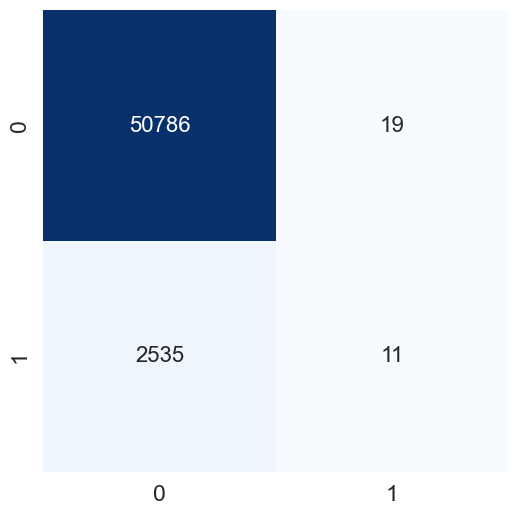

In [369]:
# Logistic regression performance with scaled data
model  = model_assess(x_train, y_train, x_test, y_test)

Accuracy of the model on the test set is 0.712
              precision    recall  f1-score   support

           0       0.99      0.71      0.82     50805
           1       0.12      0.80      0.21      2546

    accuracy                           0.71     53351
   macro avg       0.55      0.75      0.52     53351
weighted avg       0.94      0.71      0.79     53351



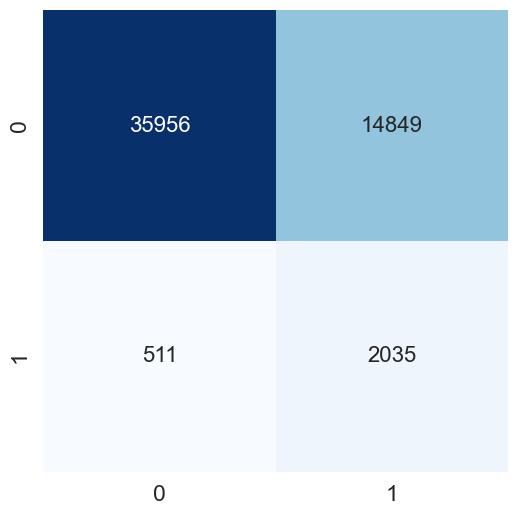

In [370]:
# Logistic regression using under-sampled train
model_undersample = model_assess(X_train_undersample, y_train_undersample, x_test, y_test)

In [371]:
# Save model and certain variables into pickle file
import pickle

# Get final columns
model_columns = heart_frame_new.columns

with open('logistic_heart_disease.pkl', 'wb') as file:
    pickle.dump([sc, model_columns, model_undersample], file)

I worked with the heart disease dataset because heart disease is one of the leading causes of death in the United States and many people do not have regular checkups with a physician. This cause of death is closely followed by cancer. Which is not as preventable as heart disease. Using a model to help predict when it is time to see a specialist could be invaluable to certain people for means of early detection or to encourage them to more regularly see a physician. The model that was used during development was the Logistic Regression model. I chose this model since my target variable "HadHeartAttack" was a binary choice of Yes/No and the relationship with the other variables were also not linear.